In [4]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Project for the Predictions and Predictability Class 2023/24

We are predicting the number of the Cyclones in the Tropical Atlantic per year, using the HURDAT2 observation dataset from the US' National Hurricane Center. 

Maybe we will additionally look into ocean surface waves or into a path of the cyclones/most cyclone genesis density.

In [5]:
df = pd.read_csv("data/tcatlantic.csv")

In [6]:
df

,Year,Tropical Storms,Hurricanes,Major Hurricanes
0,1851,6,3,1
1,1852,5,5,1
2,1853,8,4,2
3,1854,5,3,1
4,1855,5,4,1
...,...,...,...,...
167,2018,15,8,2
168,2019,18,6,3
169,2020,30,14,7
170,2021,21,7,4


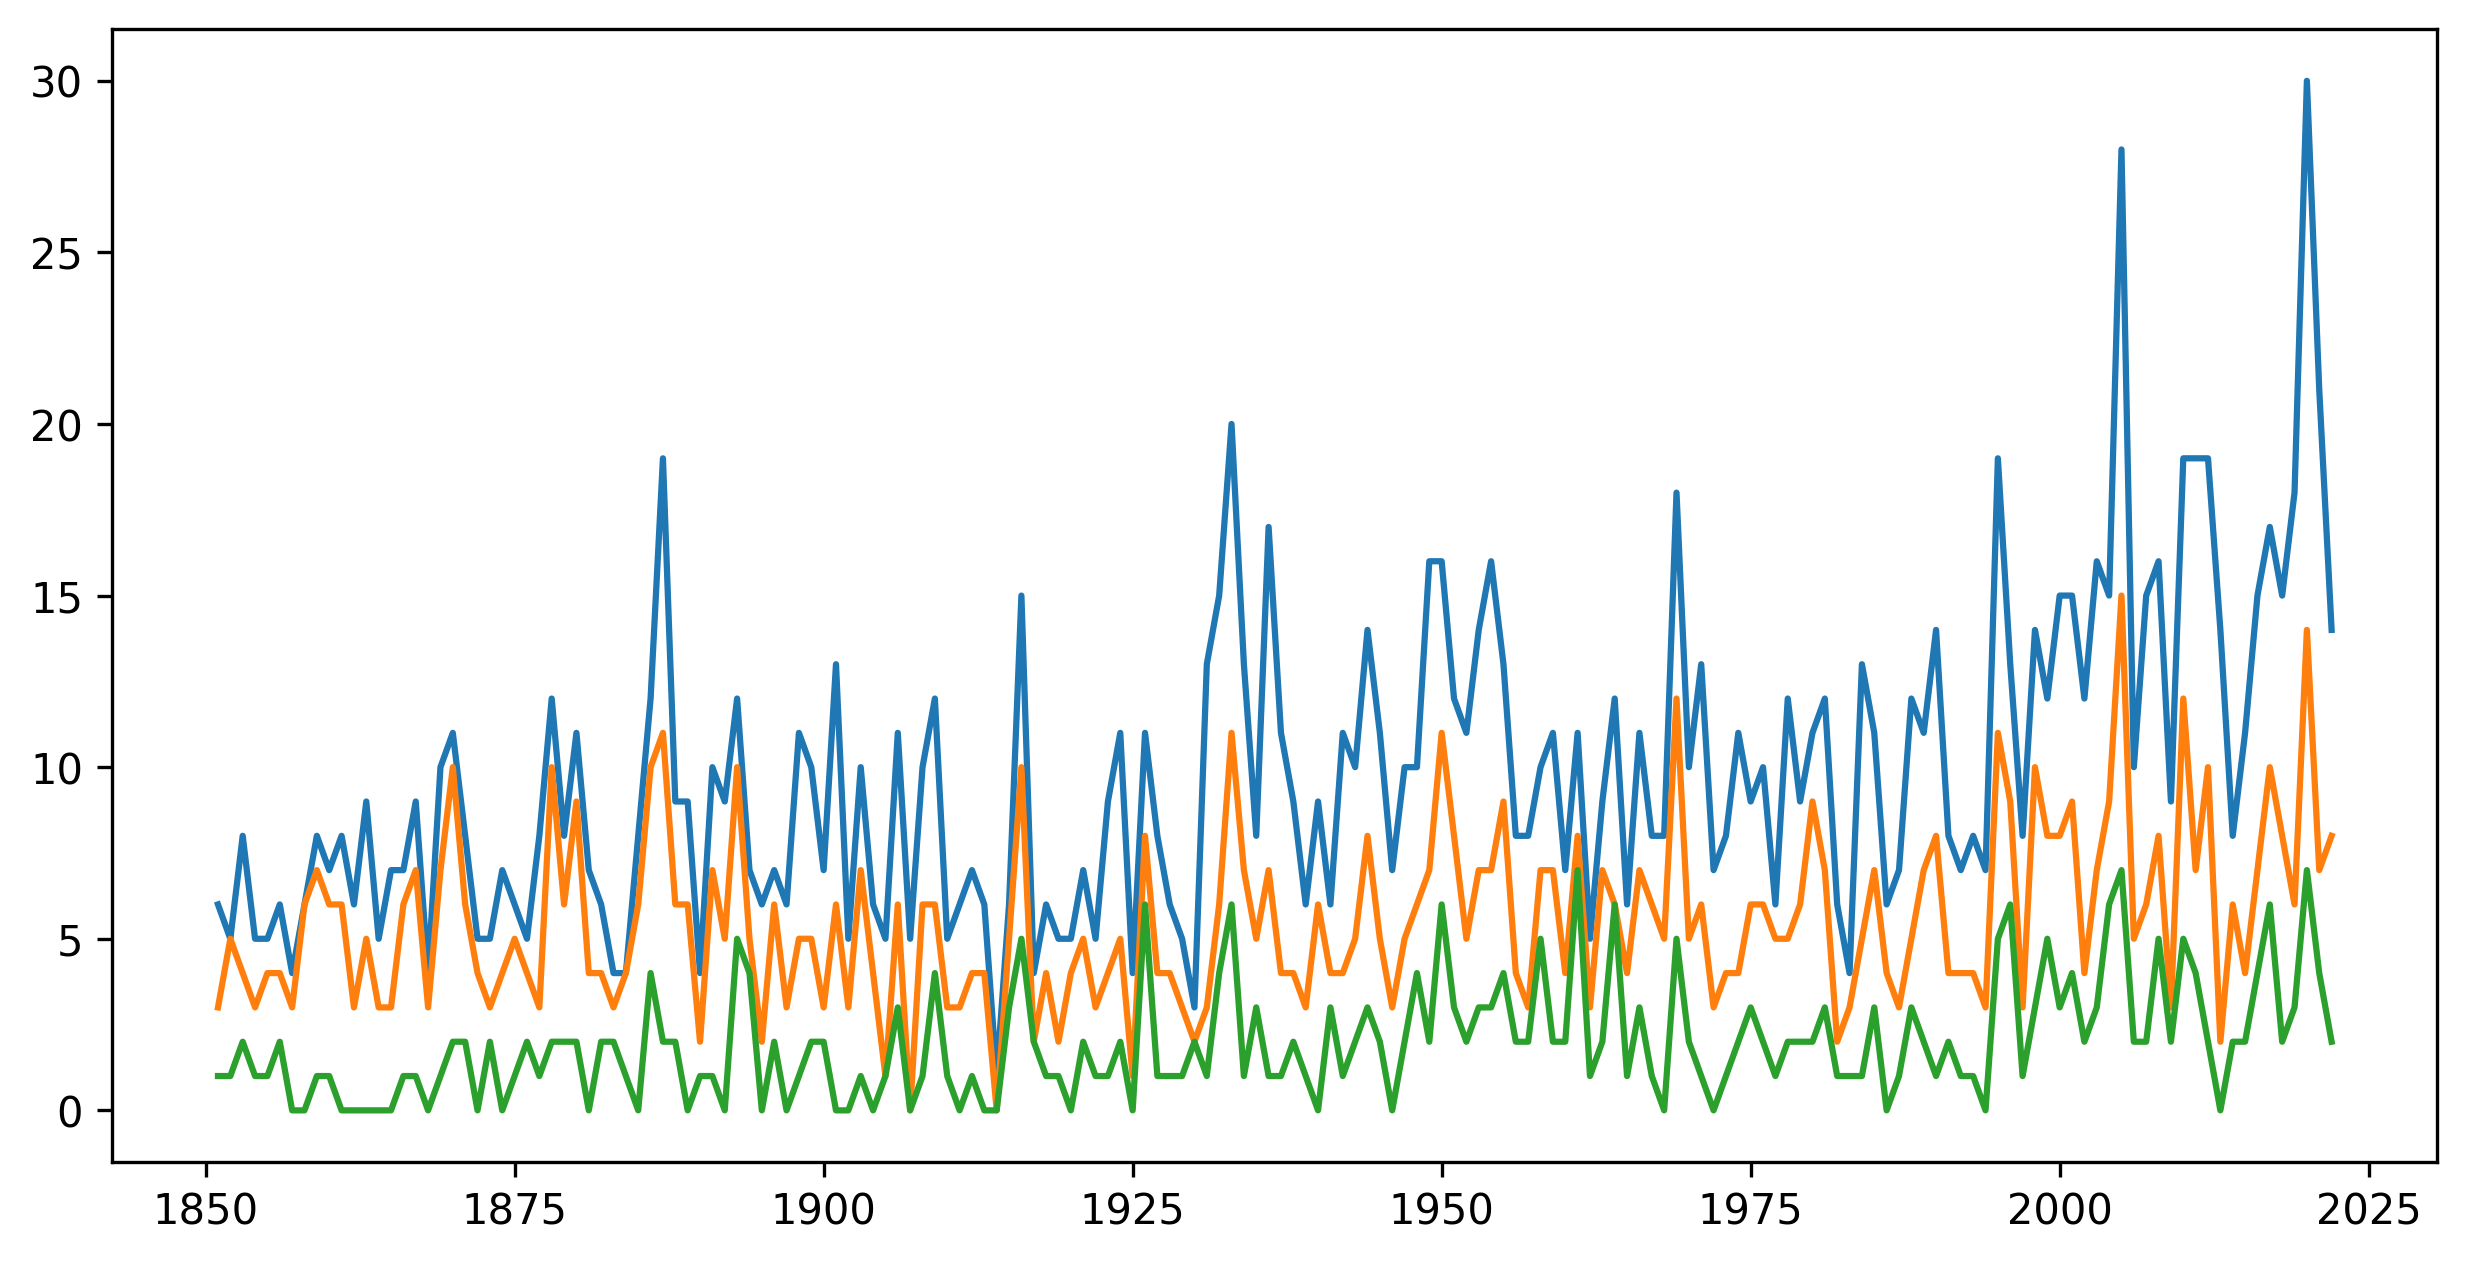

In [15]:
plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Tropical Storms")
plt.plot(df["Year"],df["Hurricanes"], label = "Hurricanes")
plt.plot(df["Year"],df["Major Hurricanes"], label = "Major Hurricanes")

In [ ]:
def clim_pred(years):
    return np.NaN